# Maze Solver Using Generic Algorithm

In [1]:
import matplotlib.pyplot as plt                # For Plotting
import numpy as np                             # For Environment Operations
import random                                  # For Genetic Algorithm  
import imageio                                 # For video recording actions
import gym                                     # The General Framework of the environment
import math                                    # Distance Calculations 
import copy                                    # Deep and shallow copies
import os                                      # Write maze runner records to disk
import pandas as pd                            # Data Analysis
from IPython.display import Image as Img
from collections import namedtuple
from pathlib import Path
from mazelab import BaseMaze                   # The Framework of the environment
from mazelab import Object
from mazelab import DeepMindColor as color
from mazelab import BaseEnv
from mazelab import VonNeumannMotion
from gym.envs.classic_control import rendering
from gym.spaces import Box
from gym.spaces import Discrete
from PIL import Image

## Initialize the Environment

In [2]:
class Env(BaseEnv):
    def __init__(self):
        super().__init__()
        # Set Maze
        self.maze = maze_env.get_maze()
        self.motions = VonNeumannMotion()
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        """
        Take action on the environment
        """
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        
        # If the result of the action to be taken is a valid position, then update the agent's position
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        # If we move to any invalid space, reward goes below the 0 so we'll know number of times we hit walls.
        reward = 0
        if self._is_goal(new_position):
            done = True
        elif not valid:
            reward = -10
            done = False
        else:
            done = False
        return self.maze.to_value(), reward, done, {}
        
    def reset(self):
        """
        Reset the Maze
        """
        self.maze.objects.agent.positions = maze_env.start_idx
        self.maze.objects.goal.positions = maze_env.goal_idx
        return self.maze.to_value()
    
    def _is_valid(self, position):
        """
        Is given position valid? or the position have some obstacle?
        """
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        """
        Have we reached to the goal position?
        """
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        """
        Convert the maze to RGB Array so that we can print it out
        """
        return self.maze.to_rgb()
    
    def render(self, mode='human', max_width=500):
        """
        Print the maze as image of max_width length.
        
        Here careful to max_width, it can make the image blurry if not equal to the actual size of the image 
        """
        img = self.get_image()
        img = np.asarray(img).astype(np.uint8)
        #img_height, img_width = img.shape[:2]
        #ratio = max_width/img_width
        img = Env.repeat_upsample(img,10, 10)
        img = np.asarray(img)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            from gym.envs.classic_control.rendering import SimpleImageViewer
            if self.viewer is None:
                self.viewer = SimpleImageViewer()
            self.viewer.imshow(img)
            
            return self.viewer.isopen
    
    # https://github.com/openai/gym/issues/550
    @staticmethod
    def repeat_upsample(rgb_array, k=1, l=1, err=[]):
        """
        Upscale the maze image by KxL
        """
        # repeat kinda crashes if k/l are zero
        if k <= 0 or l <= 0: 
            if not err: 
                print(f"Number of repeats must be larger than 0, k: {k}, l: {l}, returning default array!")
                err.append('logged')
            return rgb_array

        # repeat the pixels k times along the y axis and l times along the x axis
        # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

        return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

In [3]:
class MazeEnvironment:
    
    def __init__(self, size, k, obstacle_len=4):
        self.size = size
        self.k = k
        self.obstacle_len = obstacle_len
        self.env = self.generate_env()
        
        self.start_idx = [[1, 1]]
        self.goal_idx = [[self.size[0]-2, self.size[1]-2]]
        self.env_id = 'SimpleEmptyMaze-v0'
        
        try:
            gym.envs.register(id=self.env_id, entry_point=Env, max_episode_steps=200)
        except:
            del gym.envs.registration.registry.env_specs[self.env_id]
            gym.envs.register(id=self.env_id, entry_point=Env, max_episode_steps=200)
    
    def get_maze(self):
        x = self.env
        class Maze(BaseMaze):
            @property
            def size(self):
                return x.shape

            def make_objects(self):
                free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
                obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
                agent = Object('agent', 2, color.agent, False, [])
                goal = Object('goal', 3, color.goal, False, [])
                return free, obstacle, agent, goal
        return Maze()
    
    def set_start(start_idx):
        self.start_idx = start_idx
    
    def set_goal(goal_idx):
        self.goal_idx = goal_idx
    
    def generate_env(self):
        """
        k -> number of obstacles
        """
        # Start environment with array of Zeros where 0's are free spaces, 1's are the walls
        arr = np.zeros(shape=self.size, dtype=int)
        # Create Left-Right Walls
        for i in range(self.size[0]):
            arr[i, 0] = 1
            arr[i, self.size[1] - 1] = 1

        # Create Bottom-Up Walls
        for i in range(self.size[1]):
            arr[0, i] = 1
            arr[self.size[0] - 1, i] = 1

        # Now environment walls are generated now lets add obstacles

        # Generate k Obstacles
        for i in range(self.k):
            # Choose random point to put the current obstacle
            row = random.randrange(1, self.size[0] - 1 - self.obstacle_len)
            column = random.randrange(1, self.size[1] - 1 - self.obstacle_len)

            # Roll dice to decide whether to put the obstacle in vertical or in horizontal shape
            isVertical = random.randint(0, 1)
            if isVertical == 1:
                for j in range(self.obstacle_len):
                    arr[row, column + j] = 1
            else:
                for j in range(self.obstacle_len):
                    arr[row + j, column] = 1

        return arr

## Generic Algorithm

In [4]:
class GenericAlg:
    
    def __init__(self, env):
        self.maze_env = env
    
    def run(self, n_generations=1_000, solution_per_population=10, n_parents=3, mutation_probability=0.5):
        # Creating the initial population
        n_genes=self.maze_env.size[0] * 2
        population_size = (solution_per_population, n_genes)
        new_population = np.random.randint(low=0, high=4, size=population_size)
        
        best_chromosomes = []
        
        for generation in range(n_generations):
            # Print the best results of current iteration
            pop_fitness = self.population_fitness(new_population)
            max_fitness = np.max(pop_fitness)
            if generation % 10 == 0:
                print(f"Generation: {generation}\tBest Fitness : {max_fitness:.2f}")
            curr_best_match_idx = np.where(pop_fitness == np.max(pop_fitness))

            # Save the best chromosome of this run
            best_chromosomes.append(copy.deepcopy(new_population[curr_best_match_idx])[0])
                                   
            # Check whether we are done or not
            n_steps_taken, curr_position = self.calculate_number_of_action_to_reach(new_population[curr_best_match_idx[0][0]])
            if GenericAlg.is_done(curr_idx=curr_position, goal_idx=self.maze_env.goal_idx):
                break

            # Calculate fitness of each chromosome by running each choromosome of actions in the maze
            fitness_values = self.population_fitness(new_population)

            # Select the best parents for mating
            best_parents = GenericAlg.select_best_parents(new_population, fitness_values, n_parents)

            # Generate next generation using cross-over
            offspring_crossover = GenericAlg.cross_over(best_parents, offspring_size=(population_size[0], population_size[1]))

            # Add some variations to offsprings using mutation.
            mutated_offsprings = GenericAlg.mutate(offspring_crossover, mutation_probability)

            # Create the new generation based on best parents and offsprings
            new_population[:,:] = mutated_offsprings
        
        return best_chromosomes
        
    def maze_runner(self, actions):
        # Make an environment
        env = gym.make(self.maze_env.env_id)

        # Number of times the agent hits to a wall
        penalties = 0

        # Number of actions taken to reach the result
        n_actions_to_reach = 0

        max_distance_taken_without_punishment = 0
        curr_distance_taken_without_punishment = 0
        cumulative_distance_taken_without_punishment = 0

        # Start 
        env.reset()

        for action in actions:
            # Take action
            _, reward, _, _ = env.step(action)   

            # If we hit a wall, reward = -10
            if reward == -10:
                penalties += 1
                if curr_distance_taken_without_punishment > max_distance_taken_without_punishment:
                    max_distance_taken_without_punishment = curr_distance_taken_without_punishment
                cumulative_distance_taken_without_punishment += curr_distance_taken_without_punishment
                curr_distance_taken_without_punishment = 0
            else:
                curr_distance_taken_without_punishment += 1

            # If we have reached to goal position
            if env.unwrapped.maze.objects.agent.positions[0] != env.unwrapped.maze.objects.goal.positions[0]:
                n_actions_to_reach += 1
        # End
        env.close()

        if max_distance_taken_without_punishment == 0:
            max_distance_taken_without_punishment = curr_distance_taken_without_punishment
        # Manhattan ve euclidian distance da bul

        curr_position = env.unwrapped.maze.objects.agent.positions[0]
        goal = env.unwrapped.maze.objects.goal.positions[0]

        euclidean_dist = GenericAlg.euclidean_distance(curr_position[0], curr_position[1], goal[0], goal[1])
        manhattan_dist = GenericAlg.manhattan_distance(curr_position[0], curr_position[1], goal[0], goal[1])
        return (n_actions_to_reach, penalties, 
                max_distance_taken_without_punishment, cumulative_distance_taken_without_punishment,
                euclidean_dist,
                manhattan_dist) 
    
    
    def calculate_number_of_action_to_reach(self, actions):
        # Make an environment
        env = gym.make(self.maze_env.env_id)
        # Start 
        env.reset()
        done = False
        # Number of actions taken to reach the result
        n_actions_to_reach = 0
        for action in actions:
            # Take action
            _, _, done, _ = env.step(action)

            # If we have reached to goal position
            if done:
                break
            else:
                n_actions_to_reach += 1
        # End
        env.close()
        return n_actions_to_reach, env.unwrapped.maze.objects.agent.positions[0]
    
    

    
    def population_fitness(self, population):
        fitness_values = np.empty(population.shape[0])
        i = 0
        # Here the population consists of list of chromosomes 
        # where each chromose is actually list of actions taken
        for chromosome in population:
            # Take the chromosome and run in the maze
            (n_actions_to_reach, penalties, 
             max_distance_taken_without_punishment, cumulative_distance_taken_without_punishment,
             euclidean_dist, manhattan_dist) = self.maze_runner(chromosome)
            # Calculate the fitness of chromosome
            chromosome_fitness = GenericAlg.fitness(population=population, 
                                         n_actions_to_reach=n_actions_to_reach,
                                         n_penalties=penalties,
                                         max_distance_taken_without_punishment=max_distance_taken_without_punishment,
                                         cumulative_distance_taken_without_punishment=cumulative_distance_taken_without_punishment,
                                         euclidean_dist=euclidean_dist, manhattan_dist=manhattan_dist)
            # Save the fitness value
            fitness_values[i] = chromosome_fitness
            i += 1

        return fitness_values
    
    def write_chromosomes_to_disk(self, best_chromosomes):
        for i in range(len(best_chromosomes)):
            self.record_generation_to_disk(best_chromosomes[i],uid=i)
    
    def record_generation_to_disk(self, actions, uid):
        env = gym.make(self.maze_env.env_id)
        env.reset()
        img = env.render('rgb_array')
        path = f'./results_/{uid}'
        if not os.path.exists(path):
            os.mkdir(path)
        env = gym.wrappers.Monitor(env, path, force=True)
        env.reset()
        for action in actions:
            _, _, done, _ = env.step(action)
            if done:
                break
        env.close()
    
    def show_best_chromosome(self, best_chromosomes):
        # Get best chromosome index
        best_match_idx = len(best_chromosomes)-1
        # Create an environment
        env = gym.make(self.maze_env.env_id)
        env.reset()
        img = env.render('rgb_array')
        # Record the environment
        env = gym.wrappers.Monitor(env, './', force=True)
        env.reset()
        for action in best_chromosomes[best_match_idx]:
            _, _, done, _ = env.step(action)
            if done:
                break
        env.close()

        f = list(Path('./').glob('*.mp4'))[0]
        reader = imageio.get_reader(f)
        f = f'./maze_{self.maze_env.env_id}.gif'
        with imageio.get_writer(f, fps=50) as writer:
            [writer.append_data(img) for img in reader]
        return Img(f)
    
    @staticmethod
    def is_done(curr_idx, goal_idx):
        if curr_idx[0] == goal_idx[0][0] and  curr_idx[1] == goal_idx[0][1]:
            return True
        return False
    
    @staticmethod
    def euclidean_distance(x1, y1, x2, y2):
        return math.sqrt((x1  - x2) ** 2 + (y1 - y2) ** 2)

    @staticmethod
    def manhattan_distance(x1, y1, x2, y2):
        return abs(x1 - x2) + abs(y1 - y2)
    
    @staticmethod
    def mutate(offspring_crossover, mutation_probability):
        """
        Mutate genes in each offspring randomly.
        """
        if mutation_probability > np.random.rand():
            for idx in range(offspring_crossover.shape[0]):
                # Number of genes to mutate
                n_genes = random.randint(0, (offspring_crossover.shape[1])//4)
                for i in range(n_genes):
                    # Choose random gene to mutate
                    random_gene = random.randint(0, offspring_crossover.shape[1]-1)
                    # Mutate
                    offspring_crossover[idx, random_gene] =  random.randint(0,3)
        return offspring_crossover
    
    @staticmethod
    def cross_over(parents, offspring_size):
        """
        Cross over the parents and get offsprings
        """
        offspring = np.empty(offspring_size)
        #  The point at which crossover takes place between two parents. Usually it is at the center.
        cross_over_point = np.uint8(offspring_size[1]/2)

        for k in range(offspring_size[0]):
            parent_1_idx = random.randint(0,parents.shape[0]-1)
            parent_2_idx = random.randint(0,parents.shape[0]-1)

            # Take each gene of the chromosome from randomly selecte parent
            genes_source = np.random.randint(low=0, high=2, size=offspring_size[1])
            for gene_idx in range(offspring_size[1]):
                if (genes_source[gene_idx] == 0):
                    # The gene will be copied from the first parent if the current gene index is 0.
                    offspring[k, gene_idx] = parents[parent_1_idx, gene_idx]
                elif (genes_source[gene_idx] == 1):
                    # The gene will be copied from the second parent if the current gene index is 1.
                    offspring[k, gene_idx] = parents[parent_2_idx, gene_idx]

        return offspring
    
    @staticmethod
    def select_best_parents(population, fitness_values, n_parents):
        """
        Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
        """
        parents = np.empty((n_parents, population.shape[1]))
        for parent in range(n_parents):
            max_fitness_idx = np.where(fitness_values == np.max(fitness_values))
            max_fitness_idx = max_fitness_idx[0][0]
            parents[parent, :] = population[max_fitness_idx, :]
            fitness_values[max_fitness_idx] = -999999
        return parents    
    
    @staticmethod
    def fitness(population, n_actions_to_reach, n_penalties, 
                max_distance_taken_without_punishment, cumulative_distance_taken_without_punishment,
                euclidean_dist, manhattan_dist):
        """
        Calculate fitness of a chromosome
        Higher the fitness value, better the current chromosome is
        """
        if n_penalties != 0:
            avg_dist_taken_without_punishment = cumulative_distance_taken_without_punishment / n_penalties
        else:
            avg_dist_taken_without_punishment = max_distance_taken_without_punishment

        euclidean_points = (1/(1+euclidean_dist))
        manhattan_points = (1/(1+manhattan_dist)) 
        distance_points = (euclidean_points + manhattan_points) * 100_000

        n_penalties_points = (1 / (1+n_penalties) ) * 1_000
        avg_dist_points = avg_dist_taken_without_punishment
        max_dist_points = max_distance_taken_without_punishment
        movement_points = n_penalties_points + avg_dist_taken_without_punishment + max_distance_taken_without_punishment

        # Try to increase difference between left-right action count and down-up action count
        action_directions = np.unique(population, return_counts=True)
        direction_points = (abs(action_directions[0][0] - action_directions[0][1]) + 
                            abs(action_directions[1][0] - action_directions[1][1])) * 10


        total_points = distance_points + movement_points + direction_points

        return total_points

In [5]:
maze_env = MazeEnvironment((20, 20), 10)    # This global maze_env must exists for Env class to work properly
ga = GenericAlg(env=maze_env)
best_chromosomes_1 = ga.run(n_generations=200, solution_per_population=50, n_parents=5)

Generation: 0	Best Fitness : 11481.13
Generation: 10	Best Fitness : 49444.00
Generation: 20	Best Fitness : 108563.27
Generation: 30	Best Fitness : 208361.33


In [6]:
ga = GenericAlg(env=maze_env)

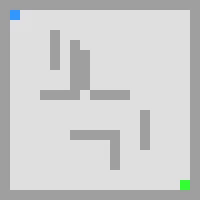

In [7]:
ga.show_best_chromosome(best_chromosomes_1)

In [8]:
ga.write_chromosomes_to_disk(best_chromosomes_1)

## Analysis

### Population Size

In [9]:
maze_env = MazeEnvironment((20, 20), 10)    # This global maze_env must exists for Env class to work properly
ga = GenericAlg(env=maze_env)
best_chromosomes_3 = ga.run(n_generations=1_000, solution_per_population=5, n_parents=3)

Generation: 0	Best Fitness : 8903.10
Generation: 10	Best Fitness : 13696.04
Generation: 20	Best Fitness : 13646.33
Generation: 30	Best Fitness : 12954.44
Generation: 40	Best Fitness : 13138.33
Generation: 50	Best Fitness : 14201.42
Generation: 60	Best Fitness : 17257.39
Generation: 70	Best Fitness : 15537.81
Generation: 80	Best Fitness : 18125.91
Generation: 90	Best Fitness : 17049.75
Generation: 100	Best Fitness : 14176.55
Generation: 110	Best Fitness : 11805.40
Generation: 120	Best Fitness : 13165.52
Generation: 130	Best Fitness : 13703.33
Generation: 140	Best Fitness : 12820.00
Generation: 150	Best Fitness : 13615.33
Generation: 160	Best Fitness : 12573.21
Generation: 170	Best Fitness : 14651.71
Generation: 180	Best Fitness : 14518.29
Generation: 190	Best Fitness : 15554.68
Generation: 200	Best Fitness : 13077.08
Generation: 210	Best Fitness : 14711.22
Generation: 220	Best Fitness : 17261.26
Generation: 230	Best Fitness : 17075.48
Generation: 240	Best Fitness : 19913.52
Generation: 

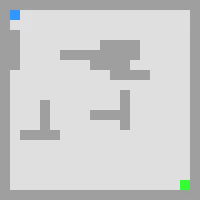

In [10]:
ga.show_best_chromosome(best_chromosomes_3)

In [11]:
data_k_20_2 = []
for i in range(5,100,20):
    ga = GenericAlg(env=maze_env)
    best_chromosome_of_run = ga.run(n_generations=1_000, solution_per_population=i, n_parents=3)
    data_k_20_2.append( (i, len(best_chromosome_of_run)) )

Generation: 0	Best Fitness : 10599.24
Generation: 10	Best Fitness : 10229.81
Generation: 20	Best Fitness : 13635.22
Generation: 30	Best Fitness : 15598.63
Generation: 40	Best Fitness : 17536.42
Generation: 50	Best Fitness : 11932.37
Generation: 60	Best Fitness : 12625.99
Generation: 70	Best Fitness : 13428.02
Generation: 80	Best Fitness : 14122.33
Generation: 90	Best Fitness : 14113.33
Generation: 100	Best Fitness : 10938.00
Generation: 110	Best Fitness : 11365.61
Generation: 120	Best Fitness : 12599.23
Generation: 130	Best Fitness : 12198.04
Generation: 140	Best Fitness : 13135.72
Generation: 150	Best Fitness : 12712.19
Generation: 160	Best Fitness : 13934.88
Generation: 170	Best Fitness : 13954.67
Generation: 180	Best Fitness : 17378.67
Generation: 190	Best Fitness : 18660.32
Generation: 200	Best Fitness : 15580.95
Generation: 210	Best Fitness : 11496.21
Generation: 220	Best Fitness : 15504.63
Generation: 230	Best Fitness : 15810.87
Generation: 240	Best Fitness : 15264.79
Generation:

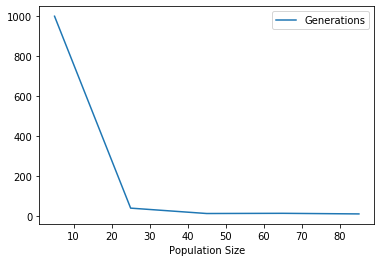

In [12]:
df = pd.DataFrame(data_k_20_2)
df.columns = ['Population Size','Generations']
df.plot(y='Generations', x='Population Size')

<font color=darkblue>PLOT#1: Population Size Vs Number of Generations </font><br/>
<font color=green>INSIGHT#1: As population size increase, number of generations tend to decrease up until certain threshold</font>
<font color=green>INSIGHT#1: When population size equal to the twice of the maze length, we get the best results</font>

In [13]:
maze_env = MazeEnvironment((20, 20), 10)    # This global maze_env must exists for Env class to work properly
ga = GenericAlg(env=maze_env)
best_chromosomes_4 = ga.run(mutation_probability=0.4, n_generations=1_000, solution_per_population=40, n_parents=3)

Generation: 0	Best Fitness : 10516.08
Generation: 10	Best Fitness : 29253.81
Generation: 20	Best Fitness : 38486.32
Generation: 30	Best Fitness : 38790.90
Generation: 40	Best Fitness : 37650.07
Generation: 50	Best Fitness : 37650.07
Generation: 60	Best Fitness : 37650.07
Generation: 70	Best Fitness : 37650.07
Generation: 80	Best Fitness : 37650.07
Generation: 90	Best Fitness : 37650.07
Generation: 100	Best Fitness : 39560.07
Generation: 110	Best Fitness : 37650.07
Generation: 120	Best Fitness : 39780.07
Generation: 130	Best Fitness : 40050.07
Generation: 140	Best Fitness : 40050.07
Generation: 150	Best Fitness : 40060.07
Generation: 160	Best Fitness : 39550.07
Generation: 170	Best Fitness : 40180.07
Generation: 180	Best Fitness : 40050.07
Generation: 190	Best Fitness : 44268.59
Generation: 200	Best Fitness : 73353.67


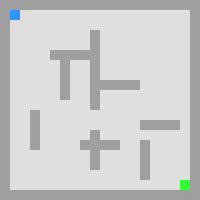

In [14]:
ga.show_best_chromosome(best_chromosomes_4)

In [ ]:
data_k_20_3 = []
for i in range(1,100,10):
    ga = GenericAlg(env=maze_env)
    best_chromosome_of_run = ga.run(mutation_probability=1/i,n_generations=1_000, solution_per_population=40, n_parents=3)
    data_k_20_3.append( (i, len(best_chromosome_of_run)) )

In [ ]:
df = pd.DataFrame(data_k_20_3)
df.columns = ['Mutation Rate','Generations']
df.plot(y='Generations', x='Mutation Rate')